In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Card Class
class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
        self.value = self.get_value()  # Get the value of the card

    def get_value(self):
        if self.rank in ['J', 'Q', 'K']:  # Face cards all have value 10
            return 10
        elif self.rank == 'A':  # Ace is 11
            return 11
        elif self.rank in ['2', '3', '4', '5', '6']:  # Number cards return their value
            return int(self.rank)
        return 10  # For 10 cards and face cards

    def __str__(self):
        return f"{self.rank} of {self.suit}"  # Just to print nicely

# Deck Class
class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks  # Set number of decks
        self.cards = self.create_deck()  # Create all cards in deck
        self.shuffle()  # Shuffle the deck

    def create_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        deck = [Card(rank, suit) for suit in suits for rank in ranks] * self.num_decks  # Build a deck with 6 sets of 52 cards
        return deck

    def shuffle(self):
        random.shuffle(self.cards)  # Shuffle the deck using random

    def draw(self):
        if len(self.cards) == 0:  # If deck is empty, reset and shuffle again
            self.cards = self.create_deck()
            self.shuffle()
        return self.cards.pop()  # Draw a card from the deck

# Player Class
class Player:
    def __init__(self, name, chips=100):
        self.name = name  # Player's name
        self.chips = chips  # Player's starting chips
        self.hand = []  # Player's hand of cards

    def hit(self, deck):
        card = deck.draw()  # Take a card from the deck
        self.hand.append(card)  # Add the card to the player's hand
        return card

    def stay(self):
        pass  # This is a placeholder, players don't do anything when they stay

    def get_hand_value(self):
        value = sum(card.value for card in self.hand)  # Add all the values of the cards in hand
        ace_count = sum(1 for card in self.hand if card.rank == 'A')  # Count Aces
        while value > 21 and ace_count > 0:  # If total value > 21, reduce Aces value from 11 to 1
            value -= 10
            ace_count -= 1
        return value  # Return total hand value

    def clear_hand(self):
        self.hand = []  # Clear hand for new round

# Dealer Class
class Dealer(Player):
    def __init__(self, name="Dealer"):
        super().__init__(name)  # Inherit from Player class

    def play_turn(self, deck):
        while self.get_hand_value() < 17:  # Dealer must keep hitting until their value is 17 or higher
            self.hit(deck)

# StrategyPlayer Class
class StrategyPlayer(Player):
    def __init__(self, name, chips=100):
        super().__init__(name, chips)  # Inherit from Player
        self.card_count = 0  # Start with no card counting

    def calculate_card_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:  # Low cards increase count
            self.card_count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:  # High cards decrease count
            self.card_count -= 1

    def decide_action(self, threshold=-2):
        if self.card_count < threshold:  # If count is low, we hit
            return 'hit'
        return 'stay'  # Otherwise we stay

# BlackjackGame Class
class BlackjackGame:
    def __init__(self, players, dealer, deck):
        self.players = players  # List of players
        self.dealer = dealer  # Dealer object
        self.deck = deck  # The deck of cards used in the game

    def start_game(self):
        self.dealer.clear_hand()  # Clear the dealer's hand
        for player in self.players:  # Clear all players' hands
            player.clear_hand()

    def deal_initial_cards(self):
        self.dealer.hit(self.deck)  # Dealer gets 2 cards
        for player in self.players:  # Each player gets 2 cards
            player.hit(self.deck)
        self.dealer.hit(self.deck)  # Dealer's second card
        for player in self.players:
            player.hit(self.deck)  # Each player’s second card

    def play_round(self):
        self.deal_initial_cards()  # Deal cards to start round

        # Players take their turns
        for player in self.players:
            while player.get_hand_value() < 21:  # While player has less than 21 points
                if isinstance(player, StrategyPlayer):  # Only StrategyPlayer can calculate card count
                    if player.decide_action() == 'hit':
                        player.hit(self.deck)
                    else:
                        break
                else:
                    break  # Normal players just stay after they have 21 or higher

        # Dealer’s turn
        self.dealer.play_turn(self.deck)

        # After all players and dealer are done, evaluate the winners
        winners = self.evaluate_winners()
        return winners

    def evaluate_winners(self):
        dealer_value = self.dealer.get_hand_value()  # Get dealer's final hand value
        winners = []
        for player in self.players:
            player_value = player.get_hand_value()  # Get each player's hand value
            if player_value > 21:
                player_value = 0  # If player busts, their value is 0
            if player_value > dealer_value:  # If player's hand is greater than dealer's, they win
                winners.append(player)
        return winners  # Return list of winners

    def play(self, rounds=50):
        results = []
        for _ in range(rounds):
            self.start_game()  # Reset the game for each round
            winners = self.play_round()  # Play one round
            for player in self.players:
                if player in winners:
                    player.chips += 1  # Winner gets 1 chip
                else:
                    player.chips -= 1  # Loser loses 1 chip
            results.append(self.players[0].chips)  # Track the strategy player's chip count after each round
        return results



Average winnings per game: -1866.42
Standard deviation: 1115.2817866351086


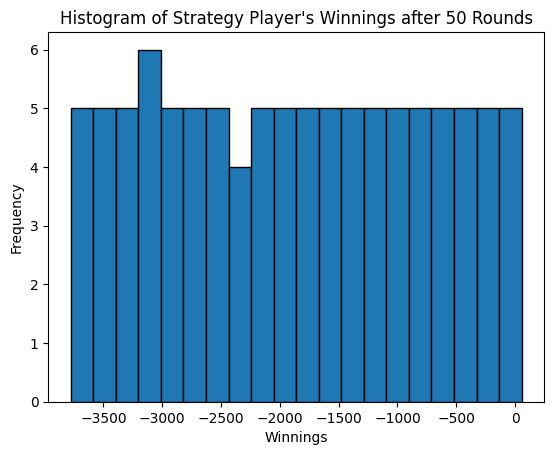

In [4]:
# Running the Simulation
def run_simulation():
    players = [StrategyPlayer("CardCounter", 100), Player("Player1"), Player("Player2"), Player("Player3")]
    dealer = Dealer()
    deck = Deck()  # Create the deck of cards

    game = BlackjackGame(players, dealer, deck)

    rounds = 50  # Number of rounds to play
    num_games = 100  # Number of games to simulate
    all_results = []  # List to store results for each game

    for _ in range(num_games):
        results = game.play(rounds)  # Play a game of 50 rounds
        all_results.append(results[-1])  # Keep the strategy player's final chip count after all rounds

    # Analyze the results after all games are done
    average_winnings = np.mean(all_results)  # Average of final chip counts
    std_dev = np.std(all_results)  # Standard deviation of the final chip counts
    print(f"Average winnings per game: {average_winnings}")
    print(f"Standard deviation: {std_dev}")

    # Plot a histogram of the strategy player's winnings
    plt.hist(all_results, bins=20, edgecolor='black')
    plt.title("Histogram of Strategy Player's Winnings after 50 Rounds")
    plt.xlabel("Winnings")
    plt.ylabel("Frequency")
    plt.show()

if __name__ == "__main__":
    run_simulation()  # Start the simulation